In [1]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import highlighting_functions as hf
from importlib import reload

_ = reload(hf)

In [2]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

import json as jorre

y = 9.77
x = [37, 2]
for k in range(x[0]):
    print((("öh" * k)))

this_variable = "hej på dig"

a_longer123string = this_variable + "ööhö"


In [3]:
tokens, tags = hf.tokenize(text)
print(tokens)

['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n\n', 'y', ' ', '=', ' ', '9', '.', '77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']):', '\n    ', 'print', '((("', 'öh', '"', ' ', '*', ' ', 'k', ')))', '\n\n', 'this_variable', ' ', '=', ' ', '"', 'hej', ' ', 'på', ' ', 'dig', '"', '\n\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"', 'ööhö', '"']
['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n', '\n', 'y', ' ', '=', ' ', '9.77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']', ')', ':', '\n', ' ', ' ', ' ', ' ', 'print', '(', '(', '(', '"öh"', ' ', '*', ' ', 'k', ')', ')', ')', '\n', '\n', 'this_variable', ' ', '=', ' ', '"hej på dig"', '\n', '\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"ööhö"']


## tagging

In [4]:
print("# tokens", len(tokens))

known_default = {
    "assign": r"=",
    "punct": r",;",
    "op": r"!%&/+-*:",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": r"for|while|foreach|as|in|if|else|elif|and|or|not",
}


# first: tag individual tokens
tokens, tags = hf.tag_individuals(tokens, tags, known_default)

# tokens 75


In [5]:
for x in zip(tags, tokens):
    if x[0] == "unk":
        print("\t".join(x))

unk	import
unk	json
unk	jorre
unk	y
unk	x
unk	k
unk	range
unk	x
unk	print
unk	k
unk	this_variable
unk	a_longer123string
unk	this_variable


## features

In [6]:
feature_names = (
    "x",
    "x",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

### bracket level

In [7]:
brac_level = []
current_level = 0
for i, token in enumerate(tokens):
    tag = tags[i]
    if tag == "brac_op":
        brac_level.append(current_level)
        current_level += 1
        tags[i] = f"brac{current_level}"
    elif tag == "brac_cl":
        tags[i] = f"brac{current_level}"
        current_level -= 1
        brac_level.append(current_level)
    else:
        brac_level.append(current_level)

feature matrix (75, 8)
(0, 'x') (1, 'x') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


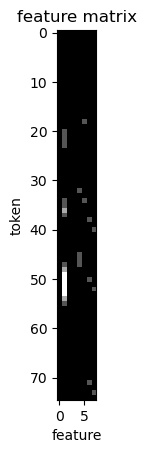

In [8]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 1] = np.array(brac_level)

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features, cmap="gray")
plt.title("feature matrix")
plt.xlabel("feature")
plt.ylabel("token")
plt.show()

## classify

(75, 2)


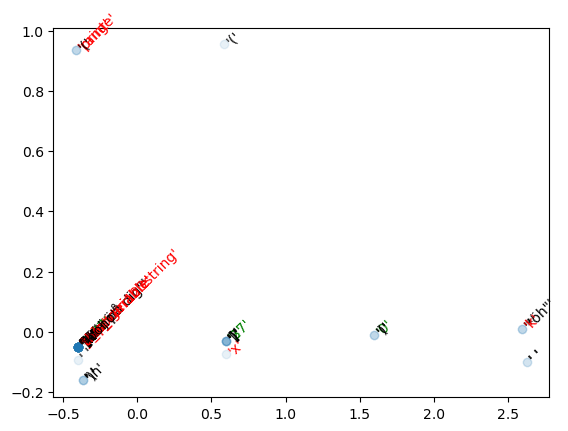

In [9]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()

pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1], alpha=0.1)
for i, t in enumerate(tokens):
    c = "#000"
    if tags[i] == "unk":
        c = "r"
    elif tags[i] == "num":
        c = "g"

    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1], s=repr(t), rotation=45, color=c)

In [10]:
classes = tuple(sorted(set(tags)))
print(classes)

('assign', 'brac1', 'brac2', 'brac3', 'keyword', 'num', 'op', 'punct', 'str', 'unk', 'wsp')


## cleanup

In [11]:
print("# tokens/tags", len(tokens))

# Merge adjacent of same class
tokens, tags = hf.merge_adjacent(tokens, tags)

print("after merge # tokens/tags", len(tokens))
print("count unknown", sum([t == "unk" for t in tags]))

# tokens/tags 75
after merge # tokens/tags 68
count unknown 13


In [12]:
print(tokens)

['import', ' ', 'json', ' ', 'as', ' ', 'jorre', '\n\n', 'y', ' ', '=', ' ', '9.77', '\n', 'x', ' ', '=', ' ', '[', '37', ',', ' ', '2', ']', '\n', 'for', ' ', 'k', ' ', 'in', ' ', 'range', '(', 'x', '[', '0', ']', ')', ':', '\n    ', 'print', '(', '(', '(', '"öh"', ' ', '*', ' ', 'k', ')', ')', ')', '\n\n', 'this_variable', ' ', '=', ' ', '"hej på dig"', '\n\n', 'a_longer123string', ' ', '=', ' ', 'this_variable', ' ', '+', ' ', '"ööhö"']


In [13]:
EXCLUDE_TAGS = ("unk", "wsp")
html_text = hf.tokens_to_html(tokens, tags, EXCLUDE_TAGS)

print(html_text)

<div class="code-snippet">import json <span class="keyword">as</span> jorre<br>
<br>
y <span class="assign">=</span> <span class="num">9.77</span><br>
x <span class="assign">=</span> <span class="brac1">[</span><span class="num">37</span><span class="punct">,</span> <span class="num">2</span><span class="brac1">]</span><br>
<span class="keyword">for</span> k <span class="keyword">in</span> range<span class="brac1">(</span>x<span class="brac2">[</span><span class="num">0</span><span class="brac2">]</span><span class="brac1">)</span><span class="op">:</span><br>
&nbsp; &nbsp; print<span class="brac1">(</span><span class="brac2">(</span><span class="brac3">(</span><span class="str">&quot;öh&quot;</span> <span class="op">*</span> k<span class="brac3">)</span><span class="brac2">)</span><span class="brac1">)</span><br>
<br>
this_variable <span class="assign">=</span> <span class="str">&quot;hej på dig&quot;</span><br>
<br>
a_longer123string <span class="assign">=</span> this_variable <span 

## output

In [14]:
css_link = '<link rel="stylesheet" type="text/css" href="_rando_style.css">'
final_html = f"""
<head>
    {css_link}
</head>
<body>
    {html_text}
</body>
"""

with open("output.html", "w") as f:
    f.write(final_html)